Importing all necessary libraries.

In [1]:
import requests
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, TimestampType
from pyspark.sql.functions import col, to_timestamp, year, when, hour, count
import matplotlib.pyplot as plt

Now, defining the URL for large dataset and fetching the crime data from API

In [2]:
# Defining the API URL for a large dataset, limited to 1 million rows
url = "https://data.cityofchicago.org/resource/ijzp-q8t2.json?$limit=1000000"

In [3]:
# Fetching Crime data from the API
response = requests.get(url)
if response.status_code == 200:
    # Converting JSON data to Pandas DataFrame
    data = response.json()
    df = pd.DataFrame(data)

    # Saving the DataFrame to CSV
    csv_path = "chicago_crimes.csv"
    df.to_csv(csv_path, index=False)
    print("Data saved to chicago_crimes.csv")
else:
    print(f"Failed to fetch data. Status code: {response.status_code}")

Data saved to chicago_crimes.csv


**CREATING THE SPARK SESSION.**

In [4]:
# Spark session

spark = SparkSession.builder \
    .appName("ChicagoCrimeAnalysis") \
    .getOrCreate()

DEFINING THE SCHEMA FOR LOADING THE DATASET

In [5]:
# Schema for the dataset

schema = StructType([
    StructField("id", StringType(), True),
    StructField("case_number", StringType(), True),
    StructField("date", StringType(), True),
    StructField("block", StringType(), True),
    StructField("iucr", StringType(), True),
    StructField("primary_type", StringType(), True),
    StructField("description", StringType(), True),
    StructField("location_description", StringType(), True),
    StructField("arrest", StringType(), True),
    StructField("domestic", StringType(), True),
    StructField("beat", StringType(), True),
    StructField("district", StringType(), True),
    StructField("ward", StringType(), True),
    StructField("community_area", StringType(), True),
    StructField("fbi_code", StringType(), True),
    StructField("x_coordinate", DoubleType(), True),
    StructField("y_coordinate", DoubleType(), True),
    StructField("year", IntegerType(), True),
    StructField("updated_on", StringType(), True),
    StructField("latitude", DoubleType(), True),
    StructField("longitude", DoubleType(), True),
    StructField("location", StringType(), True)
])

**LOAD THE CRIME DATA.**

In [6]:
# Loading the data into Spark DataFrame

spark_df = spark.read.csv("chicago_crimes.csv", header=True, inferSchema=True)

# Checking the number of rows and display some records
print(f"Spark DataFrame shape: {spark_df.count()} rows")
spark_df.show(5)


Spark DataFrame shape: 1000000 rows
+--------+-----------+-------------------+-------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+-------------------+------------+-------------+--------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+
|      id|case_number|               date|              block|iucr|        primary_type|         description|location_description|arrest|domestic|beat|district|ward|community_area|fbi_code|x_coordinate|y_coordinate|year|         updated_on|    latitude|    longitude|            location|:@computed_region_awaf_s7ux|:@computed_region_6mkv_f3dw|:@computed_region_vrxf_vc4k|:@computed_region_bdys_3d7i|:@computed_region_43wa_

**CLEANING THE DATA:**

Remove all null values

In [7]:
# Counting the null values
null_counts = spark_df.select([count(when(col(c).isNull(), c)).alias(c) for c in spark_df.columns])
null_counts.show()

+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------+--------+---------+--------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+
| id|case_number|date|block|iucr|primary_type|description|location_description|arrest|domestic|beat|district|ward|community_area|fbi_code|x_coordinate|y_coordinate|year|updated_on|latitude|longitude|location|:@computed_region_awaf_s7ux|:@computed_region_6mkv_f3dw|:@computed_region_vrxf_vc4k|:@computed_region_bdys_3d7i|:@computed_region_43wa_7qmu|:@computed_region_rpca_8um6|:@computed_region_d9mm_jgwp|:@computed_region_d3ds_rm58|:@computed_region_8hcu_yrd4|
+---+-----------+----+-----+----+------------+-----------+--------------------

In [8]:
# Removing rows with null values
spark_df_cleaned = spark_df.dropna()
print(f"After removing nulls: {spark_df_cleaned.count()} rows")
spark_df_cleaned.show(5)

After removing nulls: 976264 rows
+--------+-----------+-------------------+-------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+-------------------+------------+-------------+--------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+
|      id|case_number|               date|              block|iucr|        primary_type|         description|location_description|arrest|domestic|beat|district|ward|community_area|fbi_code|x_coordinate|y_coordinate|year|         updated_on|    latitude|    longitude|            location|:@computed_region_awaf_s7ux|:@computed_region_6mkv_f3dw|:@computed_region_vrxf_vc4k|:@computed_region_bdys_3d7i|:@computed_region_43wa_7q

Change 'Date' column data type

In [9]:
# Converting the 'date' column to TimestampType
spark_df_cleaned = spark_df_cleaned.withColumn("date", to_timestamp(col("date"), "MM/dd/yyyy hh:mm:ss a"))
print(f"After date conversion: {spark_df_cleaned.count()} rows")
spark_df_cleaned.show(5)

After date conversion: 976264 rows
+--------+-----------+-------------------+-------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+-------------------+------------+-------------+--------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+
|      id|case_number|               date|              block|iucr|        primary_type|         description|location_description|arrest|domestic|beat|district|ward|community_area|fbi_code|x_coordinate|y_coordinate|year|         updated_on|    latitude|    longitude|            location|:@computed_region_awaf_s7ux|:@computed_region_6mkv_f3dw|:@computed_region_vrxf_vc4k|:@computed_region_bdys_3d7i|:@computed_region_43wa_7

FILTERING THE DATASET FOR 10 YEARS

In [10]:
# Range of years in the DataFrame
spark_df_cleaned.select(year(col("date")).alias("year")).distinct().show()

# Filtering for the last ten years
current_year = 2024  # Update based on the current year
spark_df_filtered = spark_df_cleaned.filter(year(col("date")) >= (current_year - 10))
print(f"After filtering for last 10 years: {spark_df_filtered.count()} rows")
spark_df_filtered.show(5)

+----+
|year|
+----+
|2023|
|2024|
|2022|
|2020|
|2021|
+----+

After filtering for last 10 years: 976264 rows
+--------+-----------+-------------------+-------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+-------------------+------------+-------------+--------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+
|      id|case_number|               date|              block|iucr|        primary_type|         description|location_description|arrest|domestic|beat|district|ward|community_area|fbi_code|x_coordinate|y_coordinate|year|         updated_on|    latitude|    longitude|            location|:@computed_region_awaf_s7ux|:@computed_region_6mkv_f3dw|:@co

REMOVE ALL RECORDS WITH THE FOLLOWING CRIME TYPES:

'NON-CRIMINAL (SUBJECT SPECIFIED)',
'OTHER OFFENSE',
'STALKING',
'NON - CRIMINAL',
'ARSON'.

In [11]:
# Showing unique crime types before filtering
spark_df_filtered.select("primary_type").distinct().show(50)  # Adjust number as needed

# Excluded crime types
excluded_crimes = [
    'NON-CRIMINAL (SUBJECT SPECIFIED)',
    'OTHER OFFENSE',
    'STALKING',
    'NON - CRIMINAL',
    'ARSON'
]

# Remove specified crime types
spark_df_final = spark_df_filtered.filter(~col("primary_type").isin(excluded_crimes))
print(f"After excluding specific crime types: {spark_df_final.count()} rows")
spark_df_final.show(5)

+--------------------+
|        primary_type|
+--------------------+
|OFFENSE INVOLVING...|
|CRIMINAL SEXUAL A...|
|            STALKING|
|PUBLIC PEACE VIOL...|
|           OBSCENITY|
|               ARSON|
|            GAMBLING|
|   CRIMINAL TRESPASS|
|             ASSAULT|
|LIQUOR LAW VIOLATION|
| MOTOR VEHICLE THEFT|
|               THEFT|
|             BATTERY|
|             ROBBERY|
|            HOMICIDE|
|    PUBLIC INDECENCY|
|   HUMAN TRAFFICKING|
|        INTIMIDATION|
|        PROSTITUTION|
|  DECEPTIVE PRACTICE|
|CONCEALED CARRY L...|
|         SEX OFFENSE|
|     CRIMINAL DAMAGE|
|           NARCOTICS|
|        NON-CRIMINAL|
|       OTHER OFFENSE|
|          KIDNAPPING|
|            BURGLARY|
|   WEAPONS VIOLATION|
|OTHER NARCOTIC VI...|
|INTERFERENCE WITH...|
|           RITUALISM|
+--------------------+

After excluding specific crime types: 910993 rows
+--------+-----------+-------------------+-------------------+----+--------------------+--------------------+------------

MERGE THE SIMILAR CRIME TYPES.

In [12]:
# Merging some similar crime types
spark_df_final = spark_df_final.withColumn(
    "primary_type",
    when(col("primary_type").isin(["SEX OFFENSE", "PROSTITUTION"]), "SEXUAL CRIMES")
    .when(col("primary_type").isin(["BURGLARY", "THEFT", "MOTOR VEHICLE THEFT", "CRIMINAL DAMAGE"]), "PROPERTY CRIMES")
    .when(col("primary_type").isin(["NARCOTICS", "OTHER NARCOTIC VIOLATION", "LIQUOR LAW VIOLATION"]), "DRUG/ALCOHOL RELATED")
    .otherwise(col("primary_type"))
)

print(f"After merging crime types: {spark_df_final.count()} rows")
spark_df_final.show(5)


After merging crime types: 910993 rows
+--------+-----------+-------------------+-------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+-------------------+------------+-------------+--------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+
|      id|case_number|               date|              block|iucr|        primary_type|         description|location_description|arrest|domestic|beat|district|ward|community_area|fbi_code|x_coordinate|y_coordinate|year|         updated_on|    latitude|    longitude|            location|:@computed_region_awaf_s7ux|:@computed_region_6mkv_f3dw|:@computed_region_vrxf_vc4k|:@computed_region_bdys_3d7i|:@computed_region_43

**DATA** **ANALYSIS**

a. Show year-wise trend of the crime for last ten years.

In [13]:
# Year-wise trend of crime
year_wise_trend = spark_df_final.groupBy(year(col("date")).alias("year")).count().orderBy("year")
year_wise_trend.show()

+----+------+
|year| count|
+----+------+
|2020| 71208|
|2021|186660|
|2022|217831|
|2023|242414|
|2024|192880|
+----+------+



b. Find out at which hour of the day crime is highest.

In [14]:
# Find out which hour has the most crimes
hour_wise_crime = spark_df_final.withColumn("hour", hour(col("date"))) \
    .groupBy("hour").count().orderBy("count", ascending=False)
hour_wise_crime.show(1)

+----+-----+
|hour|count|
+----+-----+
|   0|65080|
+----+-----+
only showing top 1 row



c. Find top ten crimes and present them as a bar chart.

In [15]:
# Top ten crimes
top_ten_crimes = spark_df_final.groupBy("primary_type").count().orderBy("count", ascending=False).limit(10)
top_ten_crimes.show()

+--------------------+------+
|        primary_type| count|
+--------------------+------+
|     PROPERTY CRIMES|439073|
|             BATTERY|176368|
|             ASSAULT| 89079|
|  DECEPTIVE PRACTICE| 63669|
|             ROBBERY| 38368|
|   WEAPONS VIOLATION| 36567|
|DRUG/ALCOHOL RELATED| 20963|
|   CRIMINAL TRESPASS| 17518|
|OFFENSE INVOLVING...|  7178|
|CRIMINAL SEXUAL A...|  6110|
+--------------------+------+



In [16]:
# Converting the top ten crimes Spark DataFrame to Pandas DataFrame
top_ten_crimes_pd = top_ten_crimes.toPandas()

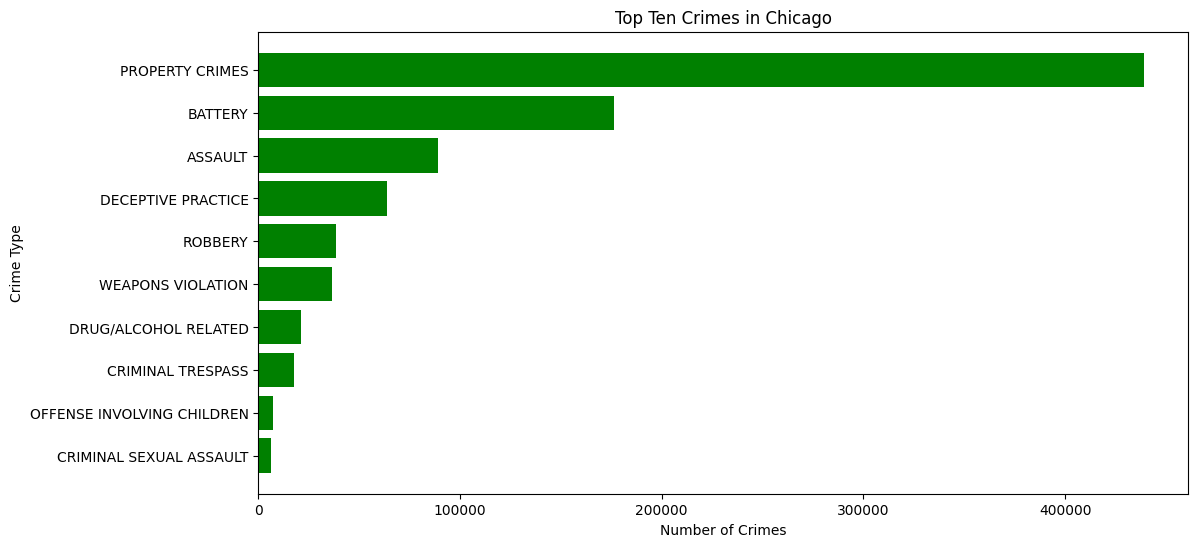

In [19]:
# Plotting the top 10 crimes
plt.figure(figsize=(12, 6))
plt.barh(top_ten_crimes_pd['primary_type'], top_ten_crimes_pd['count'], color='green')
plt.xlabel('Number of Crimes')
plt.ylabel('Crime Type')
plt.title('Top Ten Crimes in Chicago')
plt.gca().invert_yaxis()
plt.show()